# Monte Carlo Markov Chain Sampling

Here we use two methods of MCMC sampling to approximate a probability distribution without knowing the exact height at any point. This can be a more tractable way to integrate a complicated, difficult distribution.

## Method One: Metropolis Hastings MCMC

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def p( x, temperature=1.0 ):
    return np.exp( -10*temperature*((x-2)**2) ) + 0.3*np.exp( -0.5*10*temperature*((x+1)**2) )

def iterate(ss):
    states = []
    x0 = 0
    states.append(x0)
    count = 0
    for iters in range(10000):
        x0 = states[-1]
        proposal = x0 + ss*np.random.randn()
        accept_prob = p(proposal)/p(x0)
        r = min([1, accept_prob])
        u = np.random.uniform(0,1)
        if (r > u):
            states.append(proposal)
            count += 1
        elif (u >= r):
            states.append(states[-1])
        acceptance = count / 10000 * 100
    return states, acceptance

def plot_histogram(states, ss):
    fig = plt.figure(figsize=(8, 3))
    num_bins = 50
    # the histogram of the data
    n, bins, patches = plt.hist(states, num_bins, normed=True, facecolor='green', alpha=0.5)
    x = np.linspace(-3, 4, 100)
    y = p(x)
    plt.plot(x, y, 'r--')
    plt.xlim(-3,4)
    plt.xlabel('Samples')
    plt.ylabel('Probability')
    plt.title('Sampling with ss = %.1f' %ss)    
    plt.show()
    
def plot_state_evolution(states, ss):
    x = range(len(states[0]))
    fig = plt.figure(figsize=(15, 3))
    for i in range(3):
        plt.plot(x, states[i])
    plt.ylabel('X_Value')
    plt.xlabel('State')
    plt.title('Sampling with ss = %.1f' %ss)    
    plt.show()

Acceptance rate for chain 0:  89.41 %
Acceptance rate for chain 1:  90.2 %
Acceptance rate for chain 2:  89.64 %


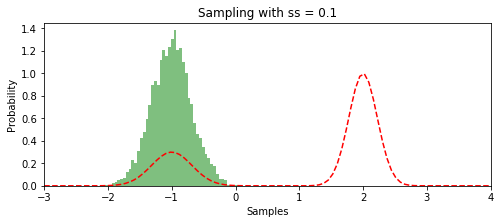

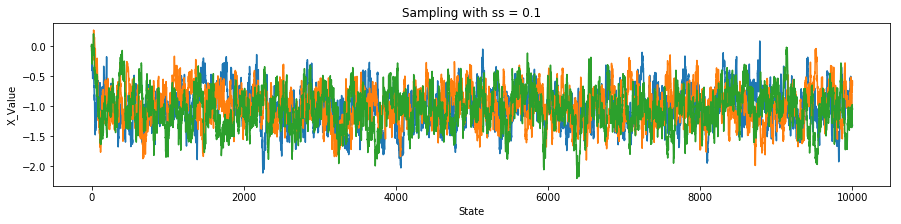

Acceptance rate for chain 0:  28.499999999999996 %
Acceptance rate for chain 1:  29.12 %
Acceptance rate for chain 2:  29.160000000000004 %


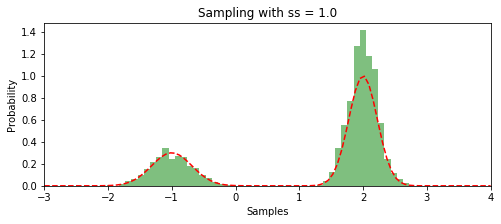

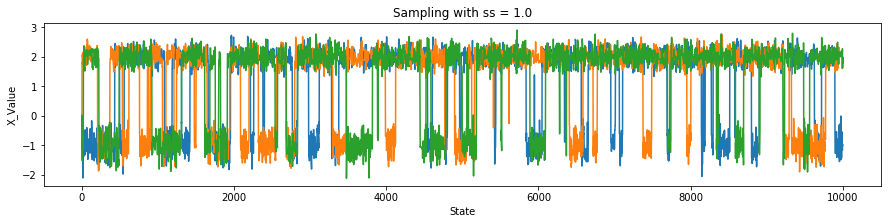

Acceptance rate for chain 0:  3.81 %
Acceptance rate for chain 1:  3.74 %
Acceptance rate for chain 2:  3.82 %


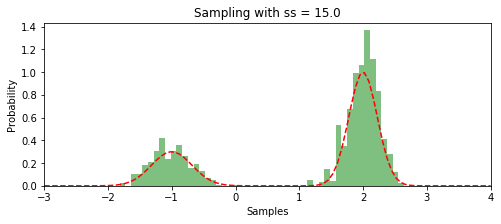

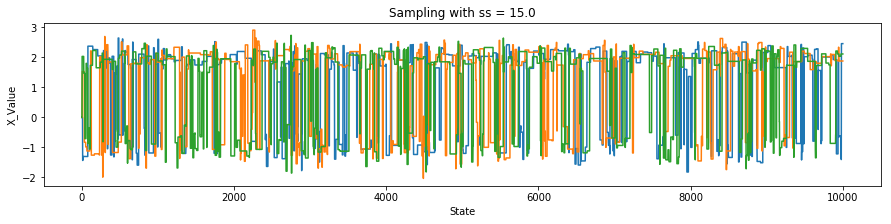

In [0]:
# Main Code 
sigma_squareds = [0.1, 1.0, 15.0]
for ss in sigma_squareds:
    states = []
    for trials in range(3):
        state, acceptance = iterate(ss)
        states.append(state)
        print("Acceptance rate for chain %i: " %trials, acceptance, "%")
    plot_histogram(states[0], ss)
    plot_state_evolution(states, ss)

## Method Two: Hamiltonian MCMC

Acceptance rate for chain 0:  100.0 %
Acceptance rate for chain 1:  100.0 %
Acceptance rate for chain 2:  100.0 %


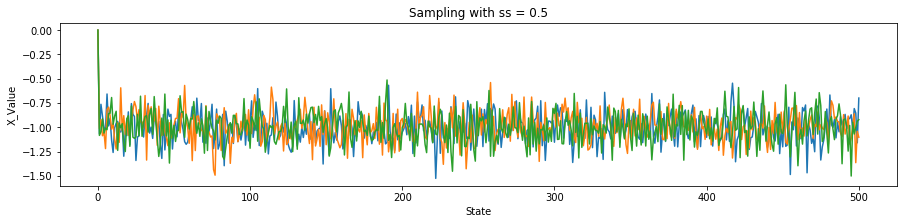

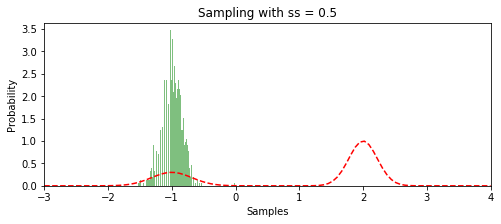

Acceptance rate for chain 0:  98.6 %
Acceptance rate for chain 1:  99.0 %
Acceptance rate for chain 2:  98.2 %


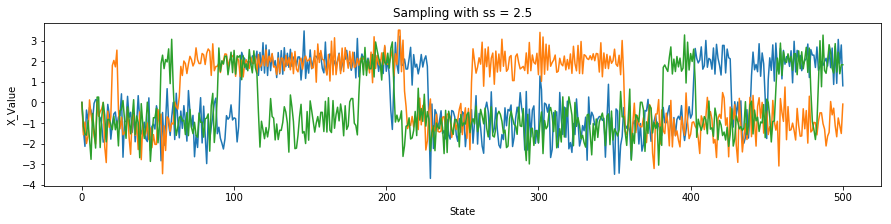

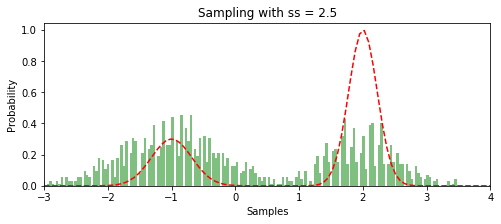

Acceptance rate for chain 0:  92.80000000000001 %
Acceptance rate for chain 1:  93.0 %
Acceptance rate for chain 2:  93.0 %


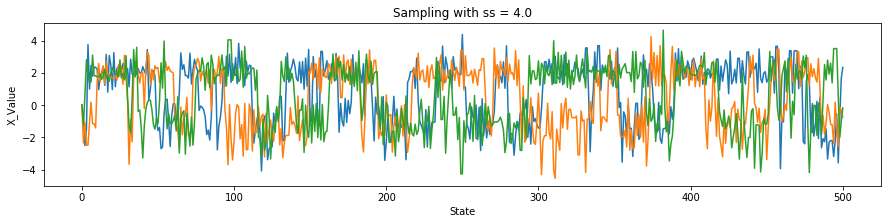

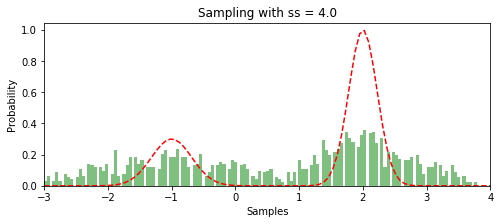

In [0]:
from autograd import grad
import autograd.numpy as np

def U(q):
    return -np.log(p(q))

def calc_hamiltonian(p, epsilon, L, ss, current_q, i):
    q = current_q
    p = ss*np.random.randn()
    current_p = p
    
    grad_U = grad(U)
    for epsilon_steps in range(L):
        # Make a half step for the momentum
        p = p - epsilon * grad_U(float(q)) / 2
        # Make a full step for the position
        q = q + epsilon * p
        # Make a half step for the momentum
        p = p - epsilon * grad_U(float(q)) / 2
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = (current_p**2) / 2
    proposed_U = U(q)
    proposed_K = (p**2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if (np.random.uniform(0,1,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return q # accept
    else:
        return current_q # reject
    

epsilon = .05
L = 10 # Number of epsilon steps between the current position and the proposal
sigma_squared = [.5, 2.5, 4] # covariance for guess of p
ITERS = 500
for ss in sigma_squared:
    states = []
    for trials in range(3):
        qs = []
        q0 = 0
        qs.append(q0)
        count = 0
        for iters in range(ITERS):
            qs.append(calc_hamiltonian(p, epsilon, L, ss, qs[-1], iters))
            if qs[iters] != qs[iters + 1]:
                count += 1
        states.append(qs)
        print("Acceptance rate for chain %i: " %trials, (count/ITERS)*100, "%")
    plot_state_evolution(states, ss)
    plot_histogram(states, ss)

In [0]:
Observations

After coding two different inference algorithms, and a few variants of each...

What was the acceptance rate of each algorithm? (ie, what percentage of proposals were accepted)
    For the MH MCMC, for low sigma-squared proposals, there was an acceptance rate of about 80%, while for high sigma-
    squared proposals, the acceptance rate was as low as 4%.
    For the Hamiltonian MCMC, for low sigma-squared proposals, the acceptance rate was almost 100%. With higher
    variance, the acceptance rate was lower, but not by much.
Why don't some inference algorithms explore both modes of the density?
    The MH algorithm only explores both modes of the density if a high sigma-squared value is given. With a low variance, 
    there are no proposals far enough from the previous state to make it to the other mode.
    Similarly, the Hamiltonian MCMC only explores both modes if the proposal for the momentum term is allowed to have a high variance.
    But with the variance of the momentum allowed to be large, we sample and accept too much probability mass outside the modes.
Why do some algorithms stay in the same state repeatedly? Is this good or bad?
    The algorithm stay in the same state repeatedly if the proposal is frequently rejected. This not necessarily a good thing,
    because it means that our proposals are not very likely. However, if many iterations are run, it allows us to explore other
    regions of probabilty that we would not reach if we chose more conservative proposals.
What were the best values for the variance of the momentum variables and the timestep? How do know that they were good?
    The best value for the variance was 2.5, because it explored both modes without spending too much time outside the expected
    distribution. The best value for the timestep was .05, because it allowed the proposal to travel without traveling too much.